In [1]:
#!pip3 install --user astropy
#!pip3 install --user kaleido

In [132]:
import numpy as np
import astropy as ap
import pandas as pd
from astropy.io import fits
import scipy.linalg as slg
from scipy.stats import norm
import scipy.stats
from math import ceil
import csv

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import kaleido

# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# from matplotlib.colors import LinearSegmentedColormap
import glob
import os
# These are in Functions
from os.path import join as pj
# from os.path import abspath as absp

from IPython.display import Image
from IPython.display import display

from joblib import Parallel, delayed

import PIL
import pickle

import sys

In [3]:
os.environ["SPARCFIRE_HOME"] = "/home/portmanm/sparcfire_matt/"

_HOME_DIR = os.path.expanduser("~")
try:
    _SPARCFIRE_DIR = os.environ["SPARCFIRE_HOME"]
    _MODULE_DIR = pj(_SPARCFIRE_DIR, "GalfitModule")
except KeyError:
    if __name__ == "__main__":
        print("SPARCFIRE_HOME is not set. Please run 'setup.bash' inside SpArcFiRe directory if not done so already.")
        print("Checking the current directory for GalfitModule, otherwise quitting.")
            
        _MODULE_DIR = pj(os.getcwd(), "GalfitModule")
        
        if not exists(_MODULE_DIR):
            raise Exception("Could not find GalfitModule!")
    
sys.path.append(_MODULE_DIR)
from Classes.Components import *
from Classes.Containers import *
from Classes.FitsHandlers import *
from Functions.helper_functions import *

In [4]:
#run_path2 = "/home/portmanm/run2_1000_galfit"
#run_path7 = "/home/portmanm/run7_1000_galfit_three_fit"
#run_path3 = "/home/portmanm/run3_1000_galfit_psf"
run_path = os.getcwd()
if in_notebook():
    run_path = run_path.replace("ics-home", "portmanm")
    
#in_dir = pj(_HOME_DIR, "29k_galaxies_obs")
#run_dir = pj(_HOME_DIR, "29k_galaxies")
in_dir  = "sparcfire-in"
out_dir = "sparcfire-out"
tmp_dir = "sparcfire-tmp"
paper_image_dir = "for_paper_images"
#galfits_tmp = "galfits"
#galfit_masks = "galfit_masks"
#galfit_out = "all_galfit_out"
nmr = "norm_masked_residual"

In [5]:
def check_galfit_chi(gal_name, base_path):
    # An example line
    # # Chi^2/nu = 4.661,  Chi^2 = 12025.575,  Ndof = 2580
    
    #galfit_txt_out = "galfit.01" # in the future galfit.01 may change
    filename = os.path.join(base_path, gal_name, galfit_txt_out)
    with open(filename, "r") as f:
        for line in f:
            if "Chi" in line:
                chi_line = line.strip("# ")
    
    # This also works but it's quite devious...
    # chi_line.replace("^", "").replace("/", "_").replace(",  ", "\n").lower()
    # exec(chi_line)
    
    out_vals = chi_line.split(",")
    chi2_nu = float(out_vals[0].strip().split("=")[-1])
    chi2 = float(out_vals[1].strip().split("=")[-1])
    ndof = int(out_vals[2].strip().split("=")[-1])
    
    return chi2_nu, chi2, ndof

In [6]:
# outpath = pj(run_path, out_dir)
# total_gal = len(glob.glob(pj(outpath, "/123*/")))

# galfit_tmp_path = pj(run_path, tmp_dir, "galfits") 
# galfit_mask_path  = pj(run_path, tmp_dir, "galfit_masks")
# all_out = [(os.path.basename(i).rstrip("_galfit_out.fits") , i) for i in glob.glob(pj(galfit_tmp_path, "*_galfit_out.fits")) if not os.path.basename(i).startswith("failed")]

In [7]:
#for x in all_out: _ = fill_objects(x)

In [206]:
basename   = "for-paper"
basename   = "GALFIT"
basename   = "bulge_n-1" 
pickle_filename = pj(out_dir, sorted(find_files(out_dir, f'{basename}_output_results*.pkl', "f"))[-1])
all_gnames = find_files(out_dir, "123*", "d")
total_gal  = len(all_gnames)

In [9]:
# gzoo_file = pj(_HOME_DIR, "kelly_stuff", "Kelly-29k.tsv")
# gzoo_data = pd.read_csv(gzoo_file, sep = "\t", index_col = "GZ_dr8objid", dtype = {"GZ_dr8objid" : str})
# gzoo_data["spirality"] = gzoo_data.P_CW + gzoo_data.P_ACW
# selected_data = gzoo_data[gzoo_data.index.isin(all_gnames)]

In [10]:
# PLOT MAX ARM LENGTH VS SPIRALITY

In [11]:
# max_arm_lengths = {}
# for gname in all_gnames:
#     csv_filename = pj(out_dir, gname, f"{gname}.csv")
#     with open(csv_filename, 'r') as f:
#         reader = csv.DictReader(f, skipinitialspace = True)
#         for row in reader:
#             max_arm_lengths[gname] = row.get('maxArcLength', None)
#             break

In [12]:
# selected_data.loc[:, "maxArcLength"] = pd.Series(max_arm_lengths, dtype = np.float32)

In [13]:
# px.scatter(selected_data, x = "maxArcLength", y = "spirality")

In [14]:
# pickle.dump(output_fits_dict, open('output_nmr.pkl', 'wb'))

In [209]:
residual_df  = pd.read_pickle(pickle_filename)
temp_df = deepcopy(residual_df)
# Setting residual columns
residual_df["KS_P"] = 1 - residual_df["KS_P"]
residual_df["nmr_x_1-p"] = residual_df["KS_P"]*residual_df["NMR"]
method = "nmr_x_1-p"

# Valid meaning NMR was successfully calculated
cols_to_drop = [col for col in residual_df.columns if col.endswith("_sky_2")]
valid_spiral_df = residual_df.drop(columns = cols_to_drop).dropna()

# rename sky_2 to sky_3 for non-spirals to be inline with everything else
# this would be for potential comparison down the line
cols_to_merge = [col for col in residual_df.columns if col.endswith("_sky_3")]
_ = [residual_df[col].fillna(residual_df[f"{col[:-1]}2"], inplace = True) for col in cols_to_merge]
residual_df.drop(columns = cols_to_drop, inplace = True)

In [210]:
sum(residual_df[method] < 0.007)

948

In [16]:
#residual_df.sort_values(by = method)

In [17]:
# For reading from pandas via single row... because there's no column method in pandas series (groan)
# feedme = FeedmeContainer()
# bulge_cols = [col for col in residual_df.columns if col.endswith("sersic_1")]
# disk_cols = [col for col in residual_df.columns if col.endswith("sersic_2")]
# arms_cols = [col for col in residual_df.columns if col.endswith("power_2")]
# fourier_cols = [col for col in residual_df.columns if col.endswith("fourier_2")]
# sky_cols = [col for col in residual_df.columns if col.endswith("sky_3")]
# gname = "1237668623019540660"
# #pd.DataFrame({i : residual_df.loc["1237668623019540660", i] for i in bulge_cols}, index = [gname])
# feedme.bulge.from_pandas(pd.DataFrame({i : residual_df.loc["1237668623019540660", i] for i in bulge_cols}, index = [gname]))
# feedme.disk.from_pandas(pd.DataFrame({i : residual_df.loc["1237668623019540660", i] for i in disk_cols}, index = [gname]))
# feedme.arms.from_pandas(pd.DataFrame({i : residual_df.loc["1237668623019540660", i] for i in arms_cols}, index = [gname]))
# feedme.fourier.from_pandas(pd.DataFrame({i : residual_df.loc["1237668623019540660", i] for i in fourier_cols}, index = [gname]))
# feedme.sky.from_pandas(pd.DataFrame({i : residual_df.loc["1237668623019540660", i] for i in sky_cols}, index = [gname]))
# feedme.to_file(filename = f"{gname}_no-incl.in")

In [18]:
#px.histogram(residual_df, x = "magnitude_sersic_1")

In [19]:
#px.histogram(residual_df, x = "magnitude_sersic_2")

In [211]:
field = " pa_alenWtd_avg_domChiralityOnly"
# {basename}_ uneccessary because different *galfit* runs 
# should have same sparcfire output
pre_sparc_output_csv = pd.read_csv(pj(out_dir, f"pre_galfit_galaxy.csv"), 
                                   index_col = "name",
                                   usecols   = ["name", field], # , " iptSz"],
                                   #na_values = "NaN",
                                   #dtype     = {field : float} #, " iptSz" : str}#, "name" : str}
                                  )#.loc[:, field]
#sparc_output_csv.index.name = None
pre_sparc_output_csv[field] = pre_sparc_output_csv[field].astype(float)
pre_sparc_output_csv.index = pre_sparc_output_csv.index.map(str)
#pre_sparc_output_csv[" iptSz"] = pre_sparc_output_csv[" iptSz"].str.extract(r"([0-9]+)").astype(float)

#pre_sparc_output_csv["pre_sign"] = np.sign(pre_sparc_output_csv[field])
pre_sparc_output_csv.rename(columns = {field : "galaxy_pre_pa"}, inplace = True)

In [212]:
field = "pitch_angle"
field_alen = "arc_length"
name_col = "gxyName"
# {basename}_
pre_sparc_output_arcs_csv = pd.read_csv(pj(out_dir, f"pre_galfit_galaxy_arcs.csv"), 
                                   index_col = name_col,
                                   usecols   = [name_col, field, field_alen],
                                   dtype     = {field : float, field_alen : float} #, name_col : str}
                                  )#.loc[:, field]
#sparc_output_csv.index.name = None
pre_sparc_output_arcs_csv.index = pre_sparc_output_arcs_csv.index.map(str)

# Filtering for pure circles and near circles
pre_sparc_output_arcs_csv = pre_sparc_output_arcs_csv[abs(pre_sparc_output_arcs_csv[field]) > 1]

#pre_sparc_output_arcs_csv = pd.concat([pre_sparc_output_arcs_csv, pre_sparc_output_csv], axis = 1)
#pre_sparc_output_arcs_csv["sign"] = np.sign(pre_sparc_output_arcs_csv[field])

# Keeps only arms which align with dom chirality only
# pre_sparc_output_arcs_csv["check"] = [
#     row["sign"] + pre_sparc_output_csv.loc[i, "pre_sign"] 
#     if i in pre_sparc_output_csv.index 
#     else None 
#     for i, row in pre_sparc_output_arcs_csv.iterrows()
# ]

#pre_sparc_output_arcs_csv = pre_sparc_output_arcs_csv[abs(pre_sparc_output_arcs_csv.loc[:, "check"]) == 2].drop(columns = ["sign", "check"])
pre_sparc_output_arcs_top3 = pre_sparc_output_arcs_csv.groupby(name_col).head(3).reset_index()
pre_sparc_output_arcs_top3["pre_sign"] = np.sign(pre_sparc_output_arcs_top3.pitch_angle)

dom_sign = np.sign(pre_sparc_output_arcs_top3.groupby(name_col).sum()["pre_sign"])
pre_sparc_output_arcs_top3 = pre_sparc_output_arcs_top3.join(dom_sign, rsuffix = "_dom", on = name_col)

cond = pre_sparc_output_arcs_top3["pre_sign_dom"] == pre_sparc_output_arcs_top3["pre_sign"]
pre_sparc_output_arcs_top2 = pre_sparc_output_arcs_top3[cond].groupby(name_col).head(2).reset_index().drop(columns = ["pre_sign_dom", "index"])

#pre_sparc_output_top2.rename(columns = {field : "pre_pa"}, inplace = True)
#pre_sparc_output_csv.dropna(inplace=True)

In [213]:
single_arm = pre_sparc_output_arcs_top2[~pre_sparc_output_arcs_top2.duplicated(name_col, keep = False)]
single_arm.loc[:, field] = 0
#single_arm.loc[:, "arc_length"]  = 0

pre_filled_in = pd.concat([pre_sparc_output_arcs_top2, single_arm], ignore_index = True)
str_fill = ["pre_pa1", "pre_pa2"] * (len(pre_filled_in) // 2)
pre_filled_in["temp1"] = str_fill

str_fill = ["pre_alen1", "pre_alen2"] * (len(pre_filled_in) // 2)
pre_filled_in["temp2"] = str_fill

#pre_filled_in = pre_filled_in.reset_index().drop(columns = ["index"])
pre_sp_out = pre_filled_in.pivot_table(index = name_col, columns = ["temp1", "temp2"], values = [field, field_alen])

pre_sp_out = pre_sp_out.droplevel(0, axis = 1).droplevel(0, axis = 1)
pre_sp_out.columns = ['pre_alen1', 'pre_alen2', 'pre_pa1', 'pre_pa2']

In [214]:
#pre_sign = pre_sparc_output_csv[~pre_sparc_output_csv.index.duplicated()].pre_sign
#pre_sp_out = pd.concat([pre_sp_out, pre_sign], axis = 1)

In [215]:
field = " pa_alenWtd_avg_domChiralityOnly"
#f"{basename}_post_galfit_galaxy.csv"
post_sparc_output_csv = pd.read_csv(pj(out_dir, f"post_galfit_galaxy.csv"), 
                                    index_col="name", 
                                    on_bad_lines = "warn",
                                    usecols = ["name", field], #, " iptSz"],
                                    #dtype = {field : float, " iptSz" : str}
                                   )

post_sparc_output_csv[field] = post_sparc_output_csv[field].astype(float)
post_sparc_output_csv.index = post_sparc_output_csv.index.map(str)
#post_sparc_output_csv[" iptSz"] = post_sparc_output_csv[" iptSz"].str.extract(r"([0-9]+)").astype(float)#split("[").str[1].str.split().str[0]#.get(1)#.str[:-1]#.slice(0,-1)

#post_sparc_output_csv["post_sign"] = np.sign(post_sparc_output_csv[field])
post_sparc_output_csv.rename(columns = {field : "galaxy_post_pa"}, inplace = True)

In [216]:
field = "pitch_angle"
field_alen = "arc_length"
name_col = "gxyName"
#f"{basename}_post_galfit_galaxy_arcs.csv"
post_sparc_output_arcs_csv = pd.read_csv(pj(out_dir, f"post_galfit_galaxy_arcs.csv"), 
                                   index_col = name_col,
                                   usecols   = [name_col, field, field_alen],
                                   dtype     = {field : float, field_alen : float} #, name_col : str}
                                  )#.loc[:, field]

post_sparc_output_arcs_csv.index = post_sparc_output_arcs_csv.index.map(str)
# Filtering for pure circles and near circles
post_sparc_output_arcs_csv = post_sparc_output_arcs_csv[abs(post_sparc_output_arcs_csv[field]) > 1]

#post_sparc_output_arcs_csv["post_sign"] = np.sign(post_sparc_output_arcs_csv[field])

# post_sparc_output_arcs_csv["check"] = [
#     row["sign"] + post_sparc_output_csv.loc[i, "post_sign"] 
#     if i in post_sparc_output_csv.index 
#     else None 
#     for i, row in post_sparc_output_arcs_csv.iterrows()
# ]

# post_sparc_output_arcs_csv  = post_sparc_output_arcs_csv[abs(post_sparc_output_arcs_csv["check"]) == 2].drop(columns = ["sign", "check"])
# post_sparc_output_arcs_top2 = post_sparc_output_arcs_csv.groupby(name_col).head(2).reset_index()

post_sparc_output_arcs_top3 = post_sparc_output_arcs_csv.groupby(name_col).head(3).reset_index()
post_sparc_output_arcs_top3["post_sign"] = np.sign(post_sparc_output_arcs_top3.pitch_angle)

dom_sign = np.sign(post_sparc_output_arcs_top3.groupby(name_col).sum()["post_sign"])
post_sparc_output_arcs_top3 = post_sparc_output_arcs_top3.join(dom_sign, rsuffix = "_dom", on = name_col)

cond = post_sparc_output_arcs_top3["post_sign_dom"] == post_sparc_output_arcs_top3["post_sign"]
post_sparc_output_arcs_top2 = post_sparc_output_arcs_top3[cond].groupby(name_col).head(2).reset_index().drop(columns = ["post_sign_dom", "index"])


In [217]:
single_arm = post_sparc_output_arcs_top2[~post_sparc_output_arcs_top2.duplicated(name_col, keep = False)]
single_arm.loc[:, field] = 0
#single_arm.loc[:, "arc_length"]  = 0

post_filled_in = pd.concat([post_sparc_output_arcs_top2, single_arm], ignore_index = True)

str_fill = ["post_pa1", "post_pa2"] * (len(post_filled_in) // 2)
post_filled_in["temp1"] = str_fill

str_fill = ["post_alen1", "post_alen2"] * (len(post_filled_in) // 2)
post_filled_in["temp2"] = str_fill

post_filled_in = post_filled_in.reset_index().drop(columns = ["index"])
post_sp_out = post_filled_in.pivot_table(index = name_col, columns = ["temp1", "temp2"], values = [field, field_alen])

post_sp_out = post_sp_out.droplevel(0, axis = 1).droplevel(0, axis = 1)
post_sp_out.columns = ['post_alen1','post_alen2','post_pa1', 'post_pa2']

In [218]:
#post_sign = post_sparc_output_csv[~post_sparc_output_csv.index.duplicated()].post_sign
#post_sp_out = pd.concat([post_sp_out, post_sign], axis = 1)

In [219]:
all_sparc_out = pd.concat([pre_sp_out, post_sp_out], axis = 1)

In [220]:
all_sparc_out

,pre_alen1,pre_alen2,pre_pa1,pre_pa2,post_alen1,post_alen2,post_pa1,post_pa2
gxyName,,,,,,,,
1237667429560025179,102.673961,100.597899,-34.377430,-23.324489,NaN,NaN,NaN,NaN
1237667429564547261,210.409657,132.800265,1.659476,20.335596,70.065377,NaN,-8.276091,NaN
1237667429565399172,190.885380,140.070021,28.819613,3.883816,152.361282,154.752038,10.321918,8.978731
1237667429569396854,133.070451,126.010631,14.467961,27.100144,27.290948,49.390639,-2.409964,-2.147004
1237667430088245574,120.607109,119.711075,22.111325,33.765853,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1237668273512972490,NaN,NaN,NaN,NaN,29.799267,73.668701,23.400795,16.155059
1237668292296441885,NaN,NaN,NaN,NaN,44.712915,28.539696,-14.649645,-7.083882
1237671140407443474,NaN,NaN,NaN,NaN,103.798535,103.614061,-29.023601,-31.490145


In [221]:
#full_df.sort_values(by = ["diff"], inplace = True)
galfit_success = deepcopy(all_sparc_out)#.dropna() #full_df.dropna(subset = ["post_pa"])
#galfit_success = galfit_success[np.sign(galfit_success.loc[:, "pre_pa"]) != np.sign(galfit_success.loc[:, "post_pa"])]

galfit_success["chiral_agreement"] = np.sign(galfit_success["pre_pa1"]) == np.sign(galfit_success["post_pa1"])

galfit_success["pre_pa1"]  = abs(galfit_success["pre_pa1"])
galfit_success["pre_pa2"]  = abs(galfit_success["pre_pa2"])
galfit_success["post_pa1"] = abs(galfit_success["post_pa1"])
galfit_success["post_pa2"] = abs(galfit_success["post_pa2"])


galfit_success["1-1"] = abs(galfit_success["pre_pa1"] - galfit_success["post_pa1"])
galfit_success["2-2"] = abs(galfit_success["pre_pa2"] - galfit_success["post_pa2"])
galfit_success["1-2"] = abs(galfit_success["pre_pa1"] - galfit_success["post_pa2"])
galfit_success["2-1"] = abs(galfit_success["pre_pa2"] - galfit_success["post_pa1"])

galfit_success["mean-1122"] = galfit_success[["1-1","2-2"]].mean(axis = "columns")
galfit_success["mean-1221"] = galfit_success[["1-2","2-1"]].mean(axis = "columns")

galfit_success["min_diff"] = galfit_success[["mean-1122", "mean-1221"]].min(axis = 1)

galfit_success["best_diffs"] = [
    (row["1-1"], row["2-2"]) if np.mean((row["1-1"], row["2-2"])) == row["min_diff"] 
    else (row["1-2"], row["2-1"]) 
    for _, row in galfit_success.iterrows()
]

galfit_success["pa_diff1"], galfit_success["pa_diff2"] = zip(*galfit_success["best_diffs"])
#galfit_success["best_diff2"] = [row["2-2"] if np.mean((row["1-1"], row["2-2"])) == row["min_diff"] else row["2-1"] for _, row in galfit_success.iterrows()]
galfit_success["pa_diff_galaxy"] = abs(abs(post_sparc_output_csv["galaxy_post_pa"]) - abs(pre_sparc_output_csv["galaxy_pre_pa"]))# < 15

# min(2_arm_length)/max(2_arm_length) > 0.7, verify that this is valid by eye
#galfit_success["alen_ratio"] = post_sparc_output_csv[" iptSz"]*galfit_success[["pre_alen1", "pre_alen2"]].min(axis = 1)/(pre_sparc_output_csv[" iptSz"]*galfit_success[["post_alen1", "post_alen2"]].max(axis = 1))
galfit_success["alen_ratio"] = galfit_success[["post_alen1", "post_alen2"]].min(axis = 1)/galfit_success[["post_alen1", "post_alen2"]].max(axis = 1)
#galfit_success.drop(columns = ["pre_sign", "post_sign"], inplace = True)

# galfit_success.loc[:, "within_15_degrees_pre"]  = galfit_success.loc[:, "diff_pre"] < 15
# galfit_success.loc[:, "within_15_degrees_post"] = galfit_success.loc[:, "diff_post"] < 15
#galfit_success.sort_values(by = ["post_pa"])

In [222]:
galfit_success = galfit_success.drop(columns = galfit_success.columns[9:-4])

In [223]:
full_df = residual_df.join(galfit_success)
full_df = full_df[full_df.index.notnull()].sort_values(by = method)

In [224]:
full_df.dropna(subset = ["pa_diff1", "pa_diff2"], how = "all", inplace = True)
full_df["min_pa_diff"] = full_df[["pa_diff1", "pa_diff2"]].min(axis = 1)

In [225]:
full_df

,magnitude_sersic_1,effective_radius_sersic_1,sersic_index_sersic_1,axis_ratio_sersic_1,position_angle_sersic_1,position_x_sersic_1,position_y_sersic_1,skip_sersic_1,magnitude_sersic_2,effective_radius_sersic_2,...,post_alen1,post_alen2,post_pa1,post_pa2,chiral_agreement,pa_diff1,pa_diff2,pa_diff_galaxy,alen_ratio,min_pa_diff
gname,,,,,,,,,,,,,,,,,,,,,
1237674604287819937,14.120100,9.183500,0.5396,0.4728,45.283100,79.180000,79.510002,0.0,14.4666,5.872000,...,18.824820,NaN,4.381163,NaN,True,NaN,25.235799,1.926475,1.000000,25.235799
1237667485918560560,12.609400,40.434101,3.1918,0.7840,89.758598,87.809998,87.449997,0.0,13.8291,16.385500,...,203.247734,203.280645,17.096798,20.577375,True,6.715170,13.209112,5.242199,0.999838,6.715170
1237668333100466390,13.772600,10.960800,1.5537,0.7056,46.989700,120.440002,120.360001,0.0,12.7294,35.879902,...,47.416603,NaN,0.712199,NaN,False,NaN,10.364159,6.048281,1.000000,10.364159
1237671262273405158,15.051100,20.936899,0.3394,0.8908,-87.659599,75.870003,76.099998,0.0,13.7739,24.222099,...,283.187330,298.345170,26.994170,26.366151,True,18.279920,9.413081,3.853575,0.949194,9.413081
1237668271916843373,16.420000,1.753800,0.9004,0.1789,-27.013700,75.959999,75.750000,0.0,12.8725,13.435400,...,61.783238,146.976075,6.689941,19.096376,False,13.580448,8.086059,11.522317,0.420363,8.086059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237673706650796557,13.585100,10.735700,0.2691,0.6441,-1.331700,46.759998,50.490002,0.0,15.3982,7.242200,...,38.664990,114.562184,18.441548,32.140185,False,9.166044,3.775263,18.544402,0.337502,3.775263
1237668270826586121,12.282100,37.995098,0.1562,0.6451,3.364400,114.989998,126.580002,0.0,11.1015,5.762800,...,329.187730,164.770747,1.977213,7.298311,True,45.591295,16.757410,2.769566,0.500537,16.757410
1237667537465770069,11.373500,54.922901,0.1685,0.2638,24.579300,151.610001,168.009995,0.0,5.2073,160.094193,...,292.108195,182.587137,25.798164,34.270111,False,16.384874,27.661475,16.716402,0.625067,16.384874


In [226]:
#full_df.loc[:, ["cumul_rot_power_2", "pre_pa1", "post_pa1"]]
#full_df[np.sign(full_df["cumul_rot_power_2"]) != np.sign(full_df["post_pa1"])].loc[:, ["cumul_rot_power_2", "pre_pa1", "post_pa1", "chiral_agreement"]]

In [227]:
cutoff_val = 0.007
residual_cutoff = full_df["nmr_x_1-p"] <= cutoff_val
pa_cutoff = (full_df["pa_diff1"] < 10) | (full_df["pa_diff2"] < 10)
alen_cutoff = full_df["alen_ratio"] > 0.7
sign_cutoff = full_df["chiral_agreement"]

success_df     = full_df[residual_cutoff & pa_cutoff & alen_cutoff & sign_cutoff]
not_success_df = full_df[~(residual_cutoff & pa_cutoff & alen_cutoff & sign_cutoff)]
#sum(full_df["nmr_x_1-p"] <= cutoff_val)

In [230]:
print(f"{len(temp_df) - sum(np.isnan(temp_df['magnitude_sersic_1']))} total models generated")
print(f"{len(temp_df) - sum(np.isnan(temp_df['inner_rad_power_2']))} with arm components")
print(f"{len(full_df)} with arms and processed by sparcfire")
print(f"{sum(residual_cutoff)} pass residual cutoff")
print(f"{sum(pa_cutoff)} pass pitch angle cutoff")
print(f"{sum(alen_cutoff)} pass arm length ratio cutoff")
print(f"{sum(sign_cutoff)} pass chiral agreement")
#print(len(success_df) + len(not_success_df), len(full_df))

1000 total models generated
930 with arm components
821 with arms and processed by sparcfire
786 pass residual cutoff
583 pass pitch angle cutoff
491 pass arm length ratio cutoff
389 pass chiral agreement


In [228]:
success_df #.sort_values(by = method)

,magnitude_sersic_1,effective_radius_sersic_1,sersic_index_sersic_1,axis_ratio_sersic_1,position_angle_sersic_1,position_x_sersic_1,position_y_sersic_1,skip_sersic_1,magnitude_sersic_2,effective_radius_sersic_2,...,post_alen1,post_alen2,post_pa1,post_pa2,chiral_agreement,pa_diff1,pa_diff2,pa_diff_galaxy,alen_ratio,min_pa_diff
gname,,,,,,,,,,,,,,,,,,,,,
1237667485918560560,12.6094,40.434101,3.1918,0.7840,89.758598,87.809998,87.449997,0.0,13.8291,16.385500,...,203.247734,203.280645,17.096798,20.577375,True,6.715170,13.209112,5.242199,0.999838,6.715170
1237671262273405158,15.0511,20.936899,0.3394,0.8908,-87.659599,75.870003,76.099998,0.0,13.7739,24.222099,...,283.187330,298.345170,26.994170,26.366151,True,18.279920,9.413081,3.853575,0.949194,9.413081
1237668494708506733,13.8762,10.434800,3.6724,0.8402,10.972800,47.240002,46.950001,0.0,14.7182,9.423400,...,123.115808,115.586351,15.183763,15.913993,True,4.489428,3.116289,1.940897,0.938842,3.116289
1237680240907124849,13.3710,18.508600,2.5716,0.4472,-37.729198,64.389999,65.199997,0.0,13.9750,15.228600,...,202.448209,167.499560,25.557963,41.168032,True,2.992572,11.820916,2.749735,0.827370,2.992572
1237678617433342002,14.4310,32.360600,19.9361,0.8360,75.205399,83.949997,83.959999,0.0,14.0152,12.755200,...,163.271667,223.524891,4.980474,22.701891,True,10.633914,0.183343,1.769152,0.730441,0.183343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237671139873128630,12.9508,9.815600,2.5855,0.4423,-86.125900,57.919998,57.930000,0.0,14.4128,15.092800,...,140.111147,103.486373,3.412586,6.957850,True,26.986344,1.106006,18.705381,0.738602,1.106006
1237668331491033433,15.1267,3.254600,5.6736,0.1665,-48.123699,41.400002,41.950001,0.0,13.4438,10.927400,...,50.687495,64.884489,3.652396,33.918538,True,13.259593,4.140327,6.601710,0.781196,4.140327
1237668297144533093,14.5493,18.736601,0.1929,0.2760,56.173302,33.820000,34.209999,0.0,13.7329,6.790000,...,55.826128,NaN,1.003165,NaN,True,NaN,7.809998,22.170989,1.000000,7.809998


In [39]:
by_eye_success_galaxies = [os.path.basename(i).replace("_galfit_out.fits", "") for i in glob(pj(out_dir, "by_eye_success", "*.fits"))]
by_eye_success_df = full_df.loc[by_eye_success_galaxies].sort_values(by = method)
by_eye_success_df

,magnitude_sersic_1,effective_radius_sersic_1,sersic_index_sersic_1,axis_ratio_sersic_1,position_angle_sersic_1,position_x_sersic_1,position_y_sersic_1,skip_sersic_1,magnitude_sersic_2,effective_radius_sersic_2,...,post_alen1,post_alen2,post_pa1,post_pa2,chiral_agreement,pa_diff1,pa_diff2,pa_diff_galaxy,alen_ratio,min_pa_diff
gname,,,,,,,,,,,,,,,,,,,,,
1237667485918560560,12.6094,40.434101,3.1918,0.7840,89.758598,87.809998,87.449997,0.0,13.8291,16.3855,...,203.280645,203.247734,20.577375,17.096798,True,10.195747,9.728535,5.242199,0.999838,9.728535
1237671262273405158,15.0354,20.897900,0.3461,0.8956,-88.252800,75.870003,76.099998,0.0,13.7847,23.9494,...,298.607929,277.515372,26.354633,26.864577,True,18.409513,9.401563,3.781618,0.929364,9.401563
1237668494708506733,13.8762,10.434800,3.6724,0.8402,10.972800,47.240002,46.950001,0.0,14.7182,9.4234,...,115.586351,123.115808,15.913993,15.183763,True,4.489428,3.116289,1.940897,0.938842,3.116289
1237671931209646271,14.3470,7.007300,0.3029,0.9988,72.650497,63.810001,63.770000,0.0,12.3285,19.4119,...,54.757598,54.997864,9.820769,9.737210,True,33.601540,14.362931,19.337228,0.995631,14.362931
1237680240907124849,13.3710,18.508600,2.5716,0.4472,-37.729198,64.389999,65.199997,0.0,13.9750,15.2286,...,202.448209,167.499560,25.557963,41.168032,True,2.992572,11.820916,2.749735,0.827370,2.992572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237667783896924233,14.5156,3.499800,3.7560,0.2599,-63.533600,52.470001,52.500000,0.0,12.9073,11.7848,...,193.751598,232.136258,6.475994,3.692782,True,10.716277,0.721472,4.023298,0.834646,0.721472
1237667536399171739,14.5547,10.583300,0.0459,0.4972,-20.028299,45.119999,44.889999,0.0,13.0256,8.6309,...,102.519031,54.909913,31.795295,3.811798,True,8.855776,13.754682,1.739769,0.535607,8.855776
1237667733958819955,13.8420,6.853000,4.7072,0.6067,-57.751301,38.730000,38.299999,0.0,13.6108,8.2416,...,173.694460,225.228403,20.420229,14.739066,True,4.905252,7.352281,2.021190,0.771193,4.905252


In [40]:
print(by_eye_success_df.loc["1237671261208576242", :])

magnitude_sersic_1                13.1569
effective_radius_sersic_1       45.615299
sersic_index_sersic_1              8.3234
axis_ratio_sersic_1                0.4778
position_angle_sersic_1        -22.618799
position_x_sersic_1             34.689999
position_y_sersic_1             34.450001
skip_sersic_1                         0.0
magnitude_sersic_2                13.2137
effective_radius_sersic_2          7.5279
sersic_index_sersic_2              1.2284
axis_ratio_sersic_2                0.4861
position_angle_sersic_2           11.2532
position_x_sersic_2             34.689701
position_y_sersic_2             34.452202
skip_sersic_2                         0.0
inner_rad_power_2                     0.0
outer_rad_power_2                  4.8966
cumul_rot_power_2                  0.3531
powerlaw_index_power_2             6.9804
inclination_power_2             33.730202
sky_position_angle_power_2      81.561203
F1_amplitude_fourier_2             0.0863
F1_phase_angle_fourier_2        23

In [41]:
success_dir = pj(out_dir, 'galfit_png')
quantile = ["0", "20", "40", "60", "80"]
for q in quantile:
    temp_str = "{images/1000_galaxies/quantile_"
    initial_str = f"\includegraphics[height=0.19\\textheight]{temp_str}{q}/"
    end_str = "}"
    for count, i in enumerate(by_eye_success_df[method][by_eye_success_df[method] >= by_eye_success_df[method].quantile(0.01*float(q), interpolation='lower')].items()):
        #if count < 5:
        #    continue
        if count == 8:
            break
        gname = i[0]
        print(q, i)
        #print(f"{initial_str}{gname + '_combined.png'}{end_str}")
        #sp(f"cp {pj(success_dir, gname + '_combined.png')} {pj(success_dir, 'all_quantile', 'quantile_' + q)}")
        #sp(f"cp {pj(out_dir, 'by_eye_success', gname + '_combined.png')} {pj(success_dir, 'all_quantile', 'quantile_' + q)}")

0 ('1237667485918560560', 0.0007797300000000003)
0 ('1237671262273405158', 0.00109164)
0 ('1237668494708506733', 0.0011923599999999997)
0 ('1237671931209646271', 0.0012563200000000002)
0 ('1237680240907124849', 0.0013035599999999998)
0 ('1237678617433342002', 0.0013067999999999999)
0 ('1237673704506130531', 0.0013611900000000002)
0 ('1237671139873915058', 0.00224)
20 ('1237668350285578377', 0.0044)
20 ('1237671690689380567', 0.0044)
20 ('1237667782849069253', 0.00442225)
20 ('1237668350288527631', 0.00442845)
20 ('1237668349757489490', 0.0044347499999999995)
20 ('1237667783363133535', 0.0044556)
20 ('1237667448346050677', 0.00445584)
20 ('1237668625164140743', 0.0044621800000000005)
40 ('1237671124294631633', 0.0047922)
40 ('1237671124841529554', 0.0048)
40 ('1237668495245508656', 0.00480396)
40 ('1237679338960453694', 0.00482735)
40 ('1237668331489591443', 0.00484398)
40 ('1237668271904588024', 0.004856500000000001)
40 ('1237671261737582774', 0.00488922)
40 ('1237667549809672337', 0.0

In [43]:
#full_df[~sign_cutoff.fillna(True)].index[:50]

In [44]:
#full_df[~sign_cutoff.fillna(False)].dropna().sort_values(by = method)

In [ ]:
#success_df[success_df.sort_values(by = method)["alen_ratio"] == 1].index

In [ ]:
#plot_df.sort_values(by = ["diff_pre_post", "nmr_x_1-p"]).iloc[:20, :]

In [66]:
def create_ecdf(x, runname, df, dict_o_kwargs):
    
    # for key, default in exec_kwargs().items():
    #     exec(f"{key} = kwargs.get({key}, {default})")
    # Yeesh https://stackoverflow.com/a/67367191
    # Use frame(2) since these functions are nested
    sys._getframe(2).f_locals.update(dict_o_kwargs)

    fig = px.ecdf(df,
                  x = x,
                  markers = True, 
                  lines = False, 
                  marginal = "histogram",
                  ecdfnorm = None
                 ) 

    if add_vline:
        fig.add_vline(x = cutoff_val, 
                      row = 1,
                      line_color = "cyan",
                      annotation_text= f"{cutoff_val}", 
                      annotation_position="bottom")

    if add_hline:
        yval = sum(df.loc[:, x] < cutoff_val)
        fig.add_hline(y = yval, 
                      row = 1,
                      col = 1,
                      line_color = "magenta",
                      annotation_text=f"{yval}",
                      annotation_position="bottom left"
                     )
        
    return fig

In [60]:
def create_scatter(x, runname, df, dict_o_kwargs):
    
    sys._getframe(2).f_locals.update(dict_o_kwargs)
        
    fig = px.scatter(plot_df, 
               x = x, 
               y = y, 
               color = color,
               color_continuous_scale = "Agsunset",
                    )
    
    return fig

In [182]:
def create_histogram(x, runname, df, dict_o_kwargs, multi):
    
    sys._getframe(2).f_locals.update(dict_o_kwargs)
    
    fig = px.histogram(
        df,
        x         = x,
        color     = color,
        histnorm  = histnorm,
        facet_col = facet_col,
        facet_row = facet_row,
        nbins     = nbins,
        #hover_data = {'Galaxy ID': (":c", full_df.index)},
        log_x     = log_x,
        log_y     = log_y,
    )
    
    if facet_col or facet_row:
        fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

    if multi:
        fig.update_layout(barmode = "overlay")
        fig.update_traces(opacity = 0.75)
        
    return fig

In [183]:
def create_plot(x, runname, plot_type, df, **kwargs):
        
    dict_o_kwargs = {
        "y"               : None,
        "color"           : None,
        
        "xaxis_title"     : "",
        "yaxis_title"     : "",
        
        "xaxis_range"     : None,
        "yaxis_range"     : None,
        
        "log_x"           : False,
        "log_y"           : False,
        
        "histnorm"        : "",
        "facet_col"       : None,
        "facet_row"       : None,
        
        "nbins"           : 0,
        
        "cutoff_val"      : 0.007,
        "add_vline"       : True,
        "add_hline"       : True,
        
        "title"           : "",
        "title_x"         : 0.9,
        "title_y"         : 0.5,

        "paper_image_dir" : "for_paper_images",
        "filetype"        : "png",
        "show"            : True,
        "write"           : True
    }
    
    # Updating with kwargs
    dict_o_kwargs = {key : kwargs.get(key, default) for key, default in dict_o_kwargs.items()}
    
    plt.clf()
    if plot_type == "ecdf":
        fig = create_ecdf(x, runname, df, dict_o_kwargs)
    elif plot_type == "scatter":
        fig = create_scatter(x, runname, df, dict_o_kwargs)
    elif plot_type == "histogram":
        multi = kwargs.get("multi", True)
        fig = create_histogram(x, runname, df, dict_o_kwargs, multi)
    else:
        return
    
    sys._getframe(1).f_locals.update(dict_o_kwargs)
    
    if title:
        fig.update_layout(
            title_text = title, 
            title_x    = title_x, 
            title_y    = title_y
        )
        
    if xaxis_title:
        fig.update_layout(xaxis_title = xaxis_title)
    if yaxis_title:
        fig.update_layout(yaxis_title = yaxis_title)
        
    if xaxis_range:
        fig.update_layout(xaxis_range = xaxis_range)
    if yaxis_range:
        fig.update_layout(yaxis_range = yaxis_range)
    
    if show:
        fig.show()
        
    if write:
        fig.write_image(f"{paper_image_dir}/{plot_type}_{runname}_{x}.{filetype}", width = 1200)
        
    return fig

In [203]:
show = False

In [118]:
plot_df = full_df[full_df.loc[:, method] < 0.015]

_ = create_plot(
    x           = method,
    runname     = "1000",
    plot_type   = "ecdf",
    df          = plot_df,
    xaxis_title = "KStest+NMR",
    # title       = f"1000 galaxies: ECDF for KStest+NMR on all models",
    # title_y     = 0.92
    show        = show
)

<Figure size 640x480 with 0 Axes>

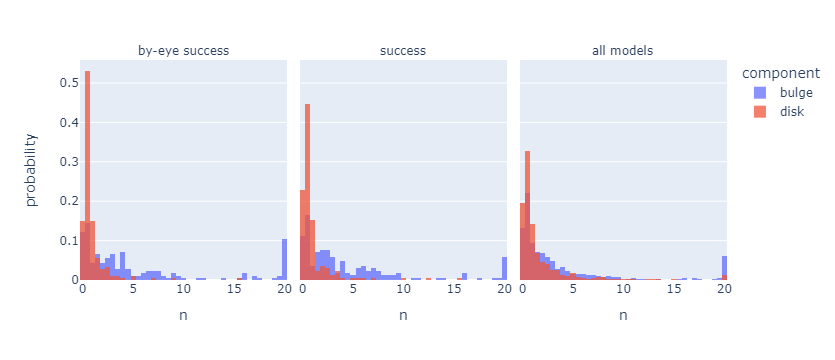

<Figure size 640x480 with 0 Axes>

In [205]:
x1   = "sersic_index_sersic_1"
x2   = "sersic_index_sersic_2"
x    = "n"
fcol = "domain"

# By eye success
plot_df = by_eye_success_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df = pd.melt(plot_df).rename(columns = {"value" : x, "variable" : "component"})
plot_df[fcol] = "by-eye success"

plot_df1 = success_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df1 = pd.melt(plot_df1).rename(columns = {"value" : x, "variable" : "component"})
plot_df1[fcol] = "success"

plot_df2 = full_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df2 = pd.melt(plot_df2).rename(columns = {"value" : x, "variable" : "component"})
plot_df2[fcol] = "all models"

plot_df = pd.concat([plot_df, plot_df1, plot_df2], axis = 0)

_ = create_plot(
    x           = x,
    runname     = "1000_by-eye-vs-success-vs-all",
    plot_type   = "histogram",
    df          = plot_df,
    histnorm    = "probability",
    color       = "component",
    nbins       = 40,
    facet_col   = fcol,
    #xaxis_range = [10, 17],
    #yaxis_range = [0, 1],
    # title       = f"{runname} galaxies: distribution of magnitudes for by-eye successful models"
    # title_y     = 0.85
    show        = True,
    write       = True
)

# _ = create_plot(
#     x           = x,
#     runname     = "1000_by-eye",
#     plot_type   = "histogram",
#     df          = plot_df,
#     color       = "component",
#     # title       = f"{runname} galaxies: distribution of Sérsic indices for by-eye successful models"
#     # title_y     = 0.85
#     show        = show
# )

# # All results
# plot_df = full_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
# plot_df = pd.melt(plot_df).rename(columns = {"value" : x, "variable" : "component"})

# _ = create_plot(
#     x           = x,
#     runname     = "1000",
#     plot_type   = "histogram",
#     df          = plot_df,
#     color       = "component",
#     # title       = f"{runname} galaxies: distribution of Sérsic indices for by-eye successful models"
#     # title_y     = 0.85
#     show        = show
# )

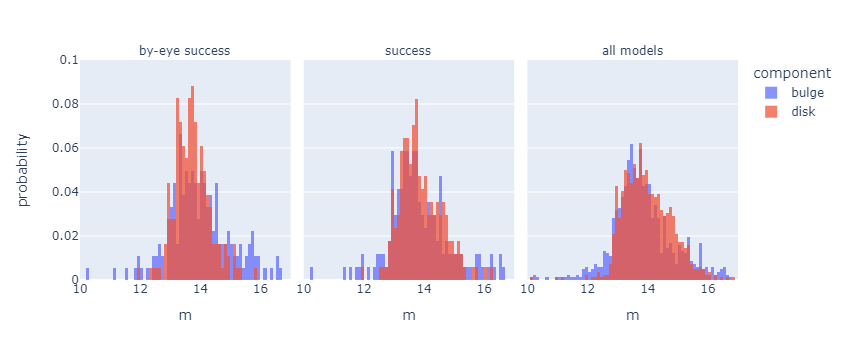

<Figure size 640x480 with 0 Axes>

In [202]:
# TODO: Combine these into one plot either using facet or go
# https://plotly.com/python/subplots/
# or https://plotly.com/python/facet-plots/

x1   = "magnitude_sersic_1"
x2   = "magnitude_sersic_2"
x    = "m"
fcol = "domain"

plot_df = by_eye_success_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df = pd.melt(plot_df).rename(columns = {"value" : x, "variable" : "component"})
plot_df[fcol] = "by-eye success"

plot_df1 = success_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df1 = pd.melt(plot_df1).rename(columns = {"value" : x, "variable" : "component"})
plot_df1[fcol] = "success"

plot_df2 = full_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df2 = pd.melt(plot_df2).rename(columns = {"value" : x, "variable" : "component"})
plot_df2[fcol] = "all models"

plot_df = pd.concat([plot_df, plot_df1, plot_df2], axis = 0)

_ = create_plot(
    x           = x,
    runname     = "1000_by-eye-vs-success-vs-all",
    plot_type   = "histogram",
    df          = plot_df,
    histnorm    = "probability",
    color       = "component",
    facet_col   = fcol,
    xaxis_range = [10, 17],
    yaxis_range = [0, 0.1],
    # title       = f"{runname} galaxies: distribution of magnitudes for by-eye successful models"
    # title_y     = 0.85
    show        = show,
    write       = True
)

# By eye
# figure1 = create_plot(
#     x           = x,
#     runname     = "1000_by-eye",
#     plot_type   = "histogram",
#     df          = plot_df,
#     color       = "component",
#     xaxis_range = [10, 17],
#     # title       = f"{runname} galaxies: distribution of magnitudes for by-eye successful models"
#     # title_y     = 0.85
#     show        = show,
#     write       = False
# )

# # All results
# plot_df = full_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
# plot_df = pd.melt(plot_df).rename(columns = {"value" : x, "variable" : "component"})

# figure2 = create_plot(
#     x           = x,
#     runname     = "1000",
#     plot_type   = "histogram",
#     df          = plot_df,
#     color       = "component",
#     xaxis_range = [10, 18],
#     # title       = f"{runname} galaxies: distribution of magnitudes for by-eye successful models"
#     # title_y     = 0.85
#     show        = show,
#     write       = False
# )

In [121]:
_ = create_plot(
    x           = "alen_ratio",
    runname     = "1000",
    plot_type   = "histogram",
    df          = full_df,
    xaxis_title = "alen ratio",
    multi       = False,
    # title       = f"{runname} galaxies: distribution of alen ratios for all models"
    # title_y     = 0.85
    show        = show
)

<Figure size 640x480 with 0 Axes>

In [122]:
_ = create_plot(
    x           = method,
    runname     = "1000_by-eye",
    plot_type   = "ecdf",
    df          = by_eye_success_df,
    xaxis_title = "KStest+NMR",
    add_hline   = False,
    # title       = f"1000 galaxies: ECDF for KStest+NMR on by-eye successful model fits",
    # title_y     = 0.92
    show        = show
)

<Figure size 640x480 with 0 Axes>

In [123]:
x     = "observation"
y     = "model"
color = "difference"

pre_pa  = full_df[["pre_pa1", "pre_pa2"]].mean(axis = 1)
post_pa = full_df[["post_pa1", "post_pa2"]].mean(axis = 1)
plot_df = pd.concat([pre_pa, post_pa], axis = 1).rename(columns = {0 : x, 1 : y})
plot_df[color] = abs(plot_df[x] - plot_df[y])

_ = create_plot(
    x         = x,
    y         = y,
    runname   = "1000_pa_diff",
    plot_type = "scatter",
    df        = plot_df,
    color     = color,
    # title     = "Pitch angle difference reported by SpArcFiRe, model vs observation"
    # title_y   = 0.85
    show      = show
)

<Figure size 640x480 with 0 Axes>

In [124]:
_ = create_plot(
    x           = "pa_diff_galaxy",
    runname     = "1000",
    plot_type   = "ecdf",
    df          = full_df,
    xaxis_title = "Pitch Angle Difference (deg)",
    cutoff_val  = 10,
    # title       = f"ECDF of pitch angle difference reported by SpArcFiRe, model vs observation"
    # title_y     = 0.85
    show        = show
)

<Figure size 640x480 with 0 Axes>

In [ ]:
x = "pa_diff_galaxy_nmr-metric"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(
    by_eye_success_df,
    x = method, 
    y = "min_pa_diff",
    #color = "chiral_agreement",
    hover_data = {'Galaxy ID': (":c", by_eye_success_df.index)},
    log_x = True,
    title = "Minimum Pitch Angle Difference (pre/post GALFIT) vs Residual Metric"
)

fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# Alternatively, call:
# fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
x = "pa_diff_galaxy_nmr-metric"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(
    full_df,
    x = method, 
    y = "pa_diff2",
    color = "chiral_agreement",
    hover_data = {'Galaxy ID': (":c", full_df.index)},
    log_x = True,
    title = "Other Pitch Angle Difference (pre/post GALFIT) vs Metric"
)

fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# Alternatively, call:
# fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
x = "pa_diff_galaxy_nmr-metric"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(
    full_df,
    x = method, 
    y = "alen_ratio",
    color = "chiral_agreement",
    hover_data = {'Galaxy ID': (":c", full_df.index)},
    log_x = True,
    title = "Arm length ratio vs Metric"
)

fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# Alternatively, call:
# fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
x = "pa_diff_galaxy_nmr-metric"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(
    full_df,
    x = "pa_diff1", 
    y = "alen_ratio",
    color = "chiral_agreement",
    hover_data = {'Galaxy ID': (":c", full_df.index)},
    #log_x = True,
    title = "Smallest Pitch Angle Difference (pre/post GALFIT) vs Arm Length Ratio"
)

fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# Alternatively, call:
# fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
# x = "pa_diff_galaxy_nmr-metric"
# runname = "1000_random"
# plot_type = "scatter"
# filetype = "png"

# #horizontal fit quality
# #vertical diff between pitch angles
# top_left_galaxies  = ["1237671122685329860", "1237680240907124849", "1237671122684215650", "1237668292835999800", "1237668272449257477"]
# bot_right_galaxies = ["1237674289682055597", "1237671261208576242", "1237668271907340482", "1237668623557263499", "1237668297681928386"]

# #plot_df = old_plot_df

# tl_to_mark = np.array([(plot_df.loc[gname, method], plot_df.loc[gname, "pa_diff_galaxy"]) for gname in top_left_galaxies])
# br_to_mark = np.array([(plot_df.loc[gname, method], plot_df.loc[gname, "pa_diff_galaxy"]) for gname in bot_right_galaxies])

# fig = px.scatter(
#     plot_df,
#     x = method, 
#     y = "pa_diff_galaxy", 
#     hover_data = {'Galaxy ID': (":c", plot_df.index)},
#     log_x = True,
#     title = "Pitch Angle Difference (pre/post GALFIT) vs Metric"
# )

# fig.add_trace(
#     go.Scatter(
#         x      = tl_to_mark[:,0], 
#         y      = tl_to_mark[:,1],
#         showlegend = False,
#         mode   = 'markers',
#         marker = dict(
#             line   = dict(width = 2),
#             symbol = 'circle-open',
#             size   = 15
#         )
#     )
#  )

# fig.add_trace(
#     go.Scatter(
#         x      = br_to_mark[:,0], 
#         y      = br_to_mark[:,1],
#         showlegend = False,
#         mode   = 'markers',
#         marker = dict(
#             line   = dict(width = 2),
#             symbol = 'circle-open',
#             size   = 15
#         )
#     )
#  )

# fig.show()
# #fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# # Alternatively, call:
# # fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
for gname in bot_right_galaxies:
    print(f"cp {gname}/*-J_logSpiralArcs* ../for_pres && ", end = "")
          #&& cp {gname}/*_combined.png ../for_pres && ", end = "")
    #print(f"cp {gname[-3:]}/{gname}/*-J_logSpiralArcs* ~/29k_galaxies/for_pres ", end = "&& ")

In [ ]:
# x = "pre-post-pa_diff"
# runname = "1000_random"
# plot_type = "scatter"
# filetype = "png"

# fig = px.scatter(galfit_success, 
#            x = "pre_pa", 
#            y = "post_pa", 
#            #color = "pa_diff_galaxy", 
#            #text = galfit_success.index, 
#            hover_data = {'Galaxy ID': (":c", galfit_success.index)},
#            color_continuous_scale = "Agsunset"
#                 )

# # fig.update_annotations(
# #     clicktoshow = "onoff"
# # )
# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
x = "pre_post-1"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(galfit_success, 
           x = "pre_pa1", 
           y = "post_pa1", 
           #color = "pa_diff_galaxy", 
           #text = galfit_success.index, 
           hover_data = {'Galaxy ID': (":c", galfit_success.index)},
           color_continuous_scale = "Agsunset"
                )

# fig.update_annotations(
#     clicktoshow = "onoff"
# )
fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
x = "pre_post-2"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(galfit_success, 
           x = "pre_pa2", 
           y = "post_pa2", 
           #color = "pa_diff_galaxy", 
           #text = galfit_success.index, 
           hover_data = {'Galaxy ID': (":c", galfit_success.index)},
           color_continuous_scale = "Agsunset"
                )

# fig.update_annotations(
#     clicktoshow = "onoff"
# )
fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
x = "pa_diffs"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(galfit_success, 
           x = "pa_diff1", 
           y = "pa_diff2", 
           #color = "pa_diff_galaxy", 
           #text = galfit_success.index, 
           hover_data = {'Galaxy ID': (":c", galfit_success.index)},
           color_continuous_scale = "Agsunset"
                )

# fig.update_annotations(
#     clicktoshow = "onoff"
# )
fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
sum((full_df["pa_diff1"] < 15) | (full_df["pa_diff2"] < 15))

In [ ]:
reduced_full_df = full_df.dropna().sort_values(method)[(full_df["pa_diff1"] < 15) | (full_df["pa_diff2"] < 15)]

In [ ]:
sum(reduced_full_df[method] < 0.007)

In [ ]:
reduced_full_df

In [ ]:
print(len(all_sparc_output.dropna()), len(galfit_success), sum(plot_df.loc[:, "pa_diff_galaxy"] < 15))

In [ ]:
#print(sum(galfit_success.loc[:, "within_15_degrees_pre"]), sum(galfit_success.loc[:, "within_15_degrees_post"]))

In [ ]:
#pitch angle
#min((a1-b1) + (a2-b2))

In [ ]:
x = "diff_sparcfire"
runname = "1000_random"
plot_type = "ecdf"
filetype = "png"
#y = "count"
fig = px.ecdf(plot_df, 
              x = x,
              #y = y,
        title = "Pitch Angle Difference reported by SpArcFiRe on an observation vs GALFIT model",
        markers = True, 
        lines = False, 
        #facet_col = "Run ", 
        marginal = "histogram",
        ecdfnorm = None,
        labels = {
                  x : "Pitch Angle Difference (deg)"#,
                  #y : y.capitalize()
                 }
       )

cutoff_diff = 15 #1
fig.add_vline(x = cutoff_diff,
              row = 1,
              line_color = "black",
              opacity = 0.5#,
              #annotation_text= f"{cutoff_diff}", 
              #annotation_position="bottom"
             )

fig.add_hline(y = sum(plot_df.loc[:, "diff_sparcfire"] < 15),
              row = 1,
              line_color = "black",
              opacity = 0.5,
              annotation_text= f"{sum(plot_df.loc[:, 'diff_sparcfire'] < 15)}", 
              annotation_position="left"
             )

# fig.update_layout({
#     'plot_bgcolor': 'rgba(0,0,0,0)',
#     'paper_bgcolor': 'rgba(0,0,0,0)'
# })


fig.show()
fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
# x = "diff_pre"
# runname = "1000_random"
# plot_type = "ecdf"
# #y = "count"
# fig = px.ecdf(galfit_success, 
#               x = x,
#               #y = y,
#         title = "Pitch Angle Difference between SpArcFiRe and GALFIT (observation vs model) on eligible spiral fits",
#         markers = True, 
#         lines = False, 
#         #facet_col = "Run ", 
#         marginal = "histogram",
#         ecdfnorm = None,
#         labels = {
#                   x : "Pitch Angle Difference (deg)"#,
#                   #y : y.capitalize()
#                  }
#        )

# cutoff_diff = 15 #1
# fig.add_vline(x = cutoff_diff,
#               row = 1,
#               line_color = "black",
#               annotation_text= f"{cutoff_diff}", 
#               annotation_position="bottom")

# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
# x = "diff_post"
# plot_type = "ecdf"
# fig = px.ecdf(galfit_success, x = x,
#               title = "Pitch Angle Difference between SpArcFiRe and GALFIT (model vs model) on eligible spiral fits",
#               markers = True, 
#               lines = False, 
#               #facet_col = "Run ", 
#               marginal = "histogram",
#               ecdfnorm = None,
#               labels = {
#                         x : "Pitch Angle Difference (deg)"
#                        }
#              )

# fig.add_vline(x = cutoff_diff,
#               row = 1,
#               line_color = "black",
#               annotation_text= f"{cutoff_diff}", 
#               annotation_position="bottom")

# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
# x = "pre_pa"
# y = "avg_pitch_angle"
# color = "within_15_degrees_pre"
# plot_type = "scatter"
# fig = px.scatter(galfit_success, 
#                  x = x,
#                  y = y,
#                  color = color,
#                  title = "Pitch Angle Difference between SpArcFiRe and GALFIT (observation vs model) on eligible spiral fits",
#                  #hover_data = ["Galaxy_Name"],
#                  labels= {
#                      x : "SpArcFiRe Pitch Angle (deg)",
#                      y : "GALFIT Pitch Angle (deg)",
#                      color : "Within 15 Degrees"#,
#                      #"Galaxy_Name" : "Galaxy Name"
#                          }
#                 )

# # fig.update_layout({
# #                    "plot_bgcolor": "rgba(0, 0, 0, 0)"#,
# #                    #"paper_bgcolor": "rgba(0, 0, 0, 0)",
# #                   })

# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
# x = "post_pa"
# y = "avg_pitch_angle"
# color = "within_15_degrees_post"
# plot_type = "scatter"
# fig = px.scatter(galfit_success, 
#                  x = x,
#                  y = y,
#                  color = color,
#                  title = "Pitch Angle Difference between SpArcFiRe and GALFIT (model vs model) on eligible spiral fits",
#                  #hover_data = ["Galaxy_Name"],
#                  labels= {
#                      x : "SpArcFiRe Pitch Angle (deg)",
#                      y : "GALFIT Pitch Angle (deg)",
#                      color : "Within 15 Degrees"#,
#                      #"Galaxy_Name" : "Galaxy Name"
#                          }
#                 )

# # fig.update_layout({
# #                    "plot_bgcolor": "rgba(0, 0, 0, 0)"#,
# #                    #"paper_bgcolor": "rgba(0, 0, 0, 0)",
# #                   })

# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
def generate_images_old(input_df, png_dir:str, variable_name:str, custom_range = None):
    images_out = []
    
    if not custom_range:
        custom_range = range(0, len(input_df), 50) 
        
    count = 0
    for index_num in custom_range:
        g_variable = input_df.iloc[index_num]
        gname = g_variable.name
        variable_value = g_variable[variable_name]#.norm_masked_residual

        height = 500
        width = 500
        size = (height, width)
        #out_str = galaxy_info.name.replace("galfit_out.fits", "combined.png").strip()
        out_str = f"{gname}_combined.png"
        #print(out_str)
        
        
        images_out.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            
        print(f"{gname}, sorted #: {index_num}")
        print(f"{variable_name} = {variable_value:.6f}")
        #print(f"Dim: {galaxy_info['image_size']}x{galaxy_info['image_size']}")
        print()
        
    return images_out

In [ ]:
images_to_disp = generate_images_old(full_df, pj(out_dir, "galfit_png"), "diff") #, range(0,len(full_df)))

In [ ]:
display(*images_to_disp)

In [ ]:
run_name = "Testing"
analysis_var = "nmr_x_1-p" #"KS_P" 
#residual_df.sort_values(by = [analysis_var], inplace = True)
plot_df.sort_values(by = ["nmr_x_1-p"], inplace = True) # "diff_pre_post"

In [ ]:
# fail_df = deepcopy(residual_df.query(f"{analysis_var} > {cutoff_val}"))
# fail_df.sort_values(by = [nmr], inplace = True)
#fail_df

In [ ]:
graphing_df = pd.DataFrame()
# graphing_df[run2_name] = nmr2_lim[nmr]
# graphing_df[run6_name] = nmr6_lim[nmr]
#graphing_df[run_name] = nmr_lim[nmr]
graphing_df[run_name] = residual_df[analysis_var]

In [ ]:
#graphing_df = graphing_df.melt(id_vars = [], value_vars = [run2_name, run6_name], var_name = "Run ", value_name = nmr, ignore_index = False)
#graphing_df = graphing_df.melt(id_vars = [], value_vars = [run_name], var_name = "Run ", value_name = nmr, ignore_index = False)
graphing_df = graphing_df.melt(id_vars = [], value_vars = [run_name], var_name = "Run ", value_name = analysis_var, ignore_index = False)

In [ ]:
# fig = px.ecdf(graphing_df, 
#               #x = nmr,
#               x = analysis_var,
#               markers = True, 
#               lines = False, 
#               #facet_col = "Run ", 
#               marginal = "histogram",
#               title = f"ECDF for kstest by {analysis_var}"
#              ) #, facet_col_wrap = 1) # 

# # yval = 0.79
# # fig.add_hline(y = yval, 
# #               row = 1,
# #               col = 1,
# #               line_color = "magenta",
# #               annotation_text=f"{yval}", #from Run7", 
# #               annotation_position="left")

# # fig.add_hline(y = 0.69,
# #               row = 1,
# #               col = 2,
# #               line_color = "cyan",
# #               annotation_text="0.78", # from Run6", 
# #               annotation_position="right")

# # cutoff_val = 0.95 #1
# # fig.add_vline(x = cutoff_val, 
# #               row = 1,
# #               line_color = "black",
# #               annotation_text= f"{cutoff_val}", 
# #               annotation_position="bottom")

# # fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim)), mode = "lines"))
# # fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75, mode = "lines"))

# # fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim))))
# # fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75))


# fig.show()

In [ ]:
# #cutoff_val_old = 0.0063
# total_gal = 1000
# # Old is with smaller fitting region
# # new is larger fitting region for better(?) sky estimation

# run_name = run_name.strip()

# print(f"Total number of galaxies attempted: {total_gal}")
# print()
# print(f"Number of Galfit models generated...")
# #print(f"{run2_name} : {len(norms2_df)}/{total_gal}")
# #print(f"{run6_name}: {len(norms6_df)}/{total_gal}")
# print(f"{run_name}: {len(residual_df)}/{total_gal}, {100*len(residual_df)/total_gal:.2f}%")
# #print(f"Old {run_name}: {len(old_df)}/{total_gal}, {100*len(old_df)/total_gal:.2f}%")

# cutoff = residual_df.query(f"{analysis_var} < {cutoff_val}")
# #cutoff_old = old_df.query(f"{analysis_var} < {cutoff_val_old}")
# print()
# print(f"Residuals below {cutoff_val} cutoff")
# print(f"{run_name}: {len(cutoff)}/{len(residual_df)}, {100*len(cutoff)/len(residual_df):.2f}%")
# #print(f"Old {run_name}: {len(cutoff_old)}/{len(old_df)}, {100*len(cutoff_old)/len(residual_df):.2f}%")
# # print()
# # print(f"Residuals below {cutoff_val} cutoff (excluding obscene failures)...")
# # print(f"{run_name}: {len(cutoff)}/{len(graphing_df)}, {100*len(cutoff)/len(graphing_df):.2f}%")

In [ ]:
def generate_images(input_df, png_dir:str, cutoff_val = 0.01, variable_name = "norm_masked_residual", custom_range = None):
    images_below_cutoff = []
    images_above_cutoff = []
    
    if not custom_range:
        custom_range = range(0, len(input_df), 50) 
    count = 0
    for index_num in custom_range:
        g_variable = input_df.iloc[index_num]
        gname = g_variable.name
        variable_value = g_variable[variable_name]#.norm_masked_residual

        # iloc returns a series, name returns the name of the row

        
        # print(f"chi^2/nu = {galaxy_info['chi^2_nu']:.2f}")
        # print(f"chi^2 = {galaxy_info['chi^2']:.2f}")
        #print(f"Norm GALFIT residual = {norm_galfit_residual:.4f}")


        # galfit_cmap = grayscale_cmap('RdBu')
        # residual_plot = plt.imshow(np.flipud(masked_residual[:,:])) #, norm=colors.LogNorm())
        # residual_plot.set_cmap('Greys')
        # residual_plot.set_cmap(galfit_cmap)
        # cbar = plt.colorbar()

        #plt.imshow(residual_plot)
        #imgplot = plt.imshow(arr[:, :, 0])
        height = 500
        width = 500
        size = (height, width)
        #out_str = galaxy_info.name.replace("galfit_out.fits", "combined.png").strip()
        out_str = f"{gname}_combined.png"
        #print(out_str)
        
        if variable_value < cutoff_val:
            images_below_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            #images_below_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))
        else:
            count += 1
            if count == 1:
                print("="*80)
            images_above_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            #images_above_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))

            
        print(f"{gname}, sorted #: {index_num}")
        print(f"{variable_name} = {variable_value:.6f}")
        #print(f"Dim: {galaxy_info['image_size']}x{galaxy_info['image_size']}")
        print()
        
    return images_below_cutoff, images_above_cutoff

In [ ]:
check_df = residual_df[residual_df.index.isin(vals_to_check)]

In [ ]:
check_df

In [ ]:
png_dir = os.path.join(run_path, out_dir, "galfit_png")
#below, above = generate_images(plot_df, png_dir, cutoff_val = 0.007, variable_name = analysis_var, custom_range = range(600, len(plot_df), 5) )
below, above = generate_images(full_df.sort_values(method), png_dir, cutoff_val = 0.007, variable_name = method, custom_range = range(850, len(full_df), 5) )
#below, above = generate_images(check_df, png_dir, cutoff_val = cutoff_val, variable_name = analysis_var, custom_range = range(0, len(check_df), 5) )

In [ ]:
display(*below)

In [ ]:
display(*above)

In [ ]:
png_dir = os.path.join(run_path, out_dir, "galfit_png")
#below, above = generate_images(residual_df, png_dir, cutoff_val = 0.013342, variable_name = analysis_var, custom_range = range(700, len(residual_df), 10) )
below, above = generate_images(residual_df, png_dir, cutoff_val = cutoff_val, variable_name = analysis_var, custom_range = range(800, len(residual_df), 10) )

In [ ]:
display(*below)

In [ ]:
display(*above)

In [ ]:
png_dir = os.path.join(run_path, out_dir, "galfit_png")
below, above = generate_images(fail_df, png_dir, cutoff_val = 1, variable_name = nmr)#, custom_range = range(650, len(residual_df), 30) )

In [ ]:
display(*below)

In [ ]:
display(*above)

In [ ]:
# gname = "1237671266033992029"
# print(residual_df.loc[gname,:])
# #gname_file = pj(out_dir, gname, f"{gname}_galfit_out.fits")
# gname_file = pj(tmp_dir, "galfits", f"{gname}_galfit_out.fits")
# # # #print(gname_file)
# gname_fit = OutputFits(gname_file)
# mask = FitsFile(pj(tmp_dir, "galfit_masks", f"{gname}_star-rm.fits"))
# gname_fit.generate_masked_residual(mask, use_bulge_mask = True)
# #print(gname_fit.nmr)
# print(1 - gname_fit.kstest.pvalue)
# #print(gname_fit.feedme) #.param_values.get("skip", 0))#.path_to_feedme)

In [ ]:
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
# Could also be useful https://eltos.github.io/gradient/#FFFFFF-A5A5A5-000000-A5A5A5-FFFFFF
# png_dir6 = os.path.join(run_path6, sparc_out, galfit_out, "galfit_png/")
# images_below_cutoff, images_above_cutoff = generate_images(norms6_df, png_dir6, cutoff = 0.1)
png_dir = os.path.join(run_path, out_dir, "galfit_png")
#images_below_cutoff, images_above_cutoff = generate_images(norms7_df, png_dir7, cutoff = 0.8)
below, above = generate_images(norms_df, png_dir, cutoff_val = cutoff_val, custom_range = range(800, len(norms_df)-10, 5))

In [ ]:
gname = "1237667431169916984_out.fits"
gname_fits = OutputFits(gname) #OutputFits(pj(out_dir, gname, gname + "_galfit_out.fits"))
print(gname_fits.feedme)

In [ ]:
good_fit = "1237671262278582530"
bad_fit = "1237668366388756890"

good_fit_obj = OutputFits(pj(out_dir, good_fit, f"{good_fit}_galfit_out.fits"))
bad_fit_obj = OutputFits(pj(out_dir, bad_fit, f"{bad_fit}_galfit_out.fits"))
good_residual = good_fit_obj.residual.data

scipy.stats.probplot(good_residual.flatten(), plot = plt)

In [ ]:
bad_residual = bad_fit_obj.residual.data
scipy.stats.probplot(bad_residual.flatten(), plot = plt)

In [ ]:
size_sorted2 = norms2_df.sort_values(by=['image_size'])[::-1]
size_sorted6 = norms6_df.sort_values(by=['image_size'])[::-1]

In [ ]:
png_dir2 = os.path.join(run_path2, sparc_out, galfit_out, "galfit_png/")
top_10_by_size2, _ = generate_images(size_sorted2, png_dir2, cutoff = 0.004, custom_range = range(10))
print("=============================================\n")
top_10_by_size6, _ = generate_images(size_sorted6, png_dir6, cutoff = 0.004, custom_range = range(10))

In [ ]:
display(*top_10_by_size6)

In [ ]:
# Grab top 1000 highest resolution galaxies from Darren's 27K and run this on those
# Change pitch angle plotting to only plot sparcfire's line between r_in and r_out and see how that compare to galfit
# Tile residuals for presentation???

In [ ]:
# Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)